# Modelado de la función sinusoidal con NeuralODEs

In [1]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso le damos a la NeuralODE una dinámica que es una combinación de funciones periódicas, con esto la NeuralODE debería ser capaz de entrenar los parámetros para poder llegar al resultado correcto.

In [2]:
function parametric_ode_system!(du,u,p,t)
    y = u
    ω, A, B = p
    du[1] = dy = A*cos(ω*2π*t) + B*sin(ω*2π*t)
  end;

Ahora seteamos el tiempo de simulación y los parámetros de la ecuación diferencial, como así la condición inicial del problema la cual es la posición inicial en 0.

In [3]:
tbegin = -1
tstep = 0.01
tend = 1
trange = tbegin:tstep:tend
p = ones(3)
tspan = (tbegin, tend)
u0 = [0.0];

Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

In [4]:
prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
function net()
    solve(prob, Tsit5(), p=p, saveat=trange)
end
sol = net()
x = vcat(sol.u...);

Generamos los datos de entrenamiento y datos de prueba de la función sinusoidal con ruido gaussiano

In [5]:
function sine_with_noise(t)
    return sin(2π*t) + rand(Normal(0,0.1))
end;

In [6]:
dataset_outs = [sine_with_noise.(trange)]
test_dataset = [sine_with_noise.(trange)];

Graficamos hora sí tanto solución de la ecuación diferencial como los datos de entrenamiento. Esto dependiendo de las condiciones iniciales aleatorias que se setearon puede estar cerca o lejos de la función sinusoidal con ruido

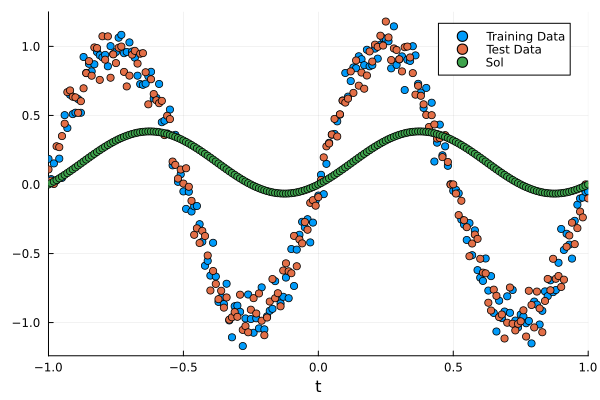

In [7]:
scatter(trange, dataset_outs, label = "Training Data")
scatter!(trange, test_dataset, label = "Test Data")
scatter!(sol, label = "Sol")

Creamos la función loss que es la diferencia entre la solución de la ecuación diferencial y los datos de entrenamiento

In [8]:
function loss_func()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, dataset_outs[1] .- pred)
  end;

In [9]:
function loss_func2()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, test_dataset[1] .- pred)
  end

loss_func2 (generic function with 1 method)

Creamos una función para ver la predicción de la red neuronal en cada época

In [10]:
function accuracy(y)
    num_correct = 0
    predictions = net()
    predictions = vcat(predictions.u...)
    for i in 1:length(predictions)
        if abs(predictions[i] - y[1][i]) < 0.2
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end;

Ahora entrenamos la red durante 150 épocas con el método de optimización Adam y un learning rate de 0.1, además en cada época guardamos los datos del loss y la presición

In [11]:
epochs = 150
learning_rate = 0.1
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)
iter = 0
losses = []
losses_test = []
accuracys = []
accuracys_test = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_func()
  println("Epoch: $iter | Loss: $actual_loss")
  push!(losses, actual_loss)
  push!(losses_test, loss_func2())
  push!(accuracys, accuracy(dataset_outs))
  push!(accuracys_test, accuracy(test_dataset))
  #plt = plot(solve(remake(prob, p=p), Tsit5()))
  #scatter!(trange, dataset_outs)
  #display(plt)
  #display(plot(solve(remake(prob,p=p),Tsit5()));
  #        scatter!(trange,dataset_outs))
end
fparams = Flux.params(p)

cb()

Flux.train!(loss_func, fparams, data, opt, cb=cb)

Epoch: 1 | Loss: 80.71461071077125
Epoch: 2 | Loss: 70.99265650195395
Epoch: 3 | Loss: 72.3971163641603
Epoch: 4 | Loss: 68.46301876752139
Epoch: 5 | Loss: 62.82609017324365
Epoch: 6 | Loss: 60.021054305788944
Epoch: 7 | Loss: 59.2603207277339
Epoch: 8 | Loss: 57.20594406842812
Epoch: 9 | Loss: 53.479668767603336
Epoch: 10 | Loss: 50.21829401721076
Epoch: 11 | Loss: 49.040936641236115
Epoch: 12 | Loss: 47.881877143708515
Epoch: 13 | Loss: 44.95224321222211
Epoch: 14 | Loss: 42.12662496258367


Epoch: 15 | Loss: 40.99440633122191
Epoch: 16 | Loss: 39.82582933983073
Epoch: 17 | Loss: 37.23860915786837
Epoch: 18 | Loss: 34.93279005345488
Epoch: 19 | Loss: 34.0524081498838
Epoch: 20 | Loss: 32.53281357014149
Epoch: 21 | Loss: 30.127765087331994
Epoch: 22 | Loss: 28.881068250690337
Epoch: 23 | Loss: 27.905286546749846
Epoch: 24 | Loss: 25.886752100468346
Epoch: 25 | Loss: 24.456685835026015


Epoch: 26 | Loss: 23.697948705867486
Epoch: 27 | Loss: 21.959529206330057
Epoch: 28 | Loss: 20.745127467402224
Epoch: 29 | Loss: 20.004150564109565
Epoch: 30 | Loss: 18.47252305312232
Epoch: 31 | Loss: 17.588359718133887
Epoch: 32 | Loss: 16.76811275918264
Epoch: 33 | Loss: 15.469578593184337
Epoch: 34 | Loss: 14.925765855901034
Epoch: 35 | Loss: 13.885020758206565
Epoch: 36 | Loss: 13.08221914939286
Epoch: 37 | Loss: 12.476820420249464
Epoch: 38 | Loss: 11.520093242633633
Epoch: 39 | Loss: 11.097301379448854
Epoch: 40 | Loss: 10.225746197434551
Epoch: 41 | Loss: 9.802616469529466
Epoch: 42 | Loss: 9.098262793202126
Epoch: 43 | Loss: 8.644067640713812
Epoch: 44 | Loss: 8.09051563118296


Epoch: 45 | Loss: 7.636013911960988
Epoch: 46 | Loss: 7.176854742959164
Epoch: 47 | Loss: 6.768969164527411
Epoch: 48 | Loss: 6.362656860709864
Epoch: 49 | Loss: 6.022711288576212
Epoch: 50 | Loss: 5.6401812074611435
Epoch: 51 | Loss: 5.382467504963655
Epoch: 52 | Loss: 5.015707844733537
Epoch: 53 | Loss: 4.82813960809625
Epoch: 54 | Loss: 4.492042923354387
Epoch: 55 | Loss: 4.328925066987027


Epoch: 56 | Loss: 4.073062940947176
Epoch: 57 | Loss: 3.881787186064442
Epoch: 58 | Loss: 3.7315854698404576
Epoch: 59 | Loss: 3.514753209792634
Epoch: 60 | Loss: 3.4120488925346226
Epoch: 61 | Loss: 3.2542488153765787
Epoch: 62 | Loss: 3.1097662078822847
Epoch: 63 | Loss: 3.0347838781460843
Epoch: 64 | Loss: 2.9029507056430277
Epoch: 65 | Loss: 2.8009354739790724
Epoch: 66 | Loss: 2.746033173928492
Epoch: 67 | Loss: 2.650302739060688
Epoch: 68 | Loss: 2.5667435023552843
Epoch: 69 | Loss: 2.5282883565258367
Epoch: 70 | Loss: 2.472139236718776
Epoch: 71 | Loss: 2.4008945783092566
Epoch: 72 | Loss: 2.361883069661782
Epoch: 73 | Loss: 2.338687659476469
Epoch: 74 | Loss: 2.297453454771865


Epoch: 75 | Loss: 2.2520653571915448
Epoch: 76 | Loss: 2.226425611464951
Epoch: 77 | Loss: 2.2145874731307162
Epoch: 78 | Loss: 2.197751215390095
Epoch: 79 | Loss: 2.171649965328087
Epoch: 80 | Loss: 2.1474628842949204
Epoch: 81 | Loss: 2.1334096538537133
Epoch: 82 | Loss: 2.1280713336981267
Epoch: 83 | Loss: 2.125262864483516
Epoch: 84 | Loss: 2.1201402085237864
Epoch: 85 | Loss: 2.11238799580922
Epoch: 86 | Loss: 2.10296415578494
Epoch: 87 | Loss: 2.0941863893322203
Epoch: 88 | Loss: 2.086848986598488
Epoch: 89 | Loss: 2.081370436924431
Epoch: 90 | Loss: 2.0774195489537854
Epoch: 91 | Loss: 2.0746432205622165
Epoch: 92 | Loss: 2.0726800353208854
Epoch: 93 | Loss: 2.0713089959824735
Epoch: 94 | Loss: 2.070390072576332
Epoch: 95 | Loss: 2.0699037180888653
Epoch: 96 | Loss: 2.0699553687934196
Epoch: 97 | Loss: 2.071028657837051
Epoch: 98 | Loss: 2.074489473008918


Epoch: 99 | Loss: 2.0847118810262244
Epoch: 100 | Loss: 2.1141056770124806
Epoch: 101 | Loss: 2.2034968236160077
Epoch: 102 | Loss: 2.4511124073537447
Epoch: 103 | Loss: 3.10792698066932
Epoch: 104 | Loss: 3.858376566828489
Epoch: 105 | Loss: 3.8095640642602233
Epoch: 106 | Loss: 2.2353487313560927
Epoch: 107 | Loss: 2.5807463920398725
Epoch: 108 | Loss: 3.471882412659802
Epoch: 109 | Loss: 2.2991532904523657
Epoch: 110 | Loss: 2.436880984584532
Epoch: 111 | Loss: 3.0703300579459682


Epoch: 112 | Loss: 2.138389022767665
Epoch: 113 | Loss: 2.5458608563737744
Epoch: 114 | Loss: 2.7365942061338946
Epoch: 115 | Loss: 2.0694538136020446
Epoch: 116 | Loss: 2.656674765360383
Epoch: 117 | Loss: 2.4038390290809457
Epoch: 118 | Loss: 2.151728089359794
Epoch: 119 | Loss: 2.600424693478069
Epoch: 120 | Loss: 2.1468155125766892
Epoch: 121 | Loss: 2.284588950211133
Epoch: 122 | Loss: 2.3800861094316517
Epoch: 123 | Loss: 2.0690829283657113
Epoch: 124 | Loss: 2.3344934360957765
Epoch: 125 | Loss: 2.1641094501696365
Epoch: 126 | Loss: 2.1329642433148224
Epoch: 127 | Loss: 2.2728225998129448
Epoch: 128 | Loss: 2.0726273009112473
Epoch: 129 | Loss: 2.2031785052950714
Epoch: 130 | Loss: 2.1685190059480477
Epoch: 131 | Loss: 2.0826620559500912


Epoch: 132 | Loss: 2.2047624659136735
Epoch: 133 | Loss: 2.093411860698922
Epoch: 134 | Loss: 2.118129110869589
Epoch: 135 | Loss: 2.1573199521243978
Epoch: 136 | Loss: 2.0688269658632197
Epoch: 137 | Loss: 2.1339896061285435
Epoch: 138 | Loss: 2.1076273649534176
Epoch: 139 | Loss: 2.075568624219755
Epoch: 140 | Loss: 2.1264027082426638
Epoch: 141 | Loss: 2.078859413585318
Epoch: 142 | Loss: 2.0882191601515436
Epoch: 143 | Loss: 2.108598153154856
Epoch: 144 | Loss: 2.0692701590558626
Epoch: 145 | Loss: 2.0943815679554563
Epoch: 146 | Loss: 2.0918406786526567
Epoch: 147 | Loss: 2.0691694319634886
Epoch: 148 | Loss: 2.093425455041894
Epoch: 149 | Loss: 2.0804438934790674
Epoch: 150 | Loss: 2.0713566627677413
Epoch: 151 | Loss: 2.0888974985509963


Una vez entrenada la NeuralODE, lo que hacemos es graficar los datos de entenamiento y los de la predicción de la red neuronal. Como se puede ver la red neuronal aprendió la función sinusoidal con ruido. Para esto lo que se logró es que los parámetros se actualicen de tal forma de que la solución de la ecuación diferencial se acerque a los datos de entrenamiento. Es por esto que volvemos a resovler el problema con los nuevos parámetros actualizados $p$

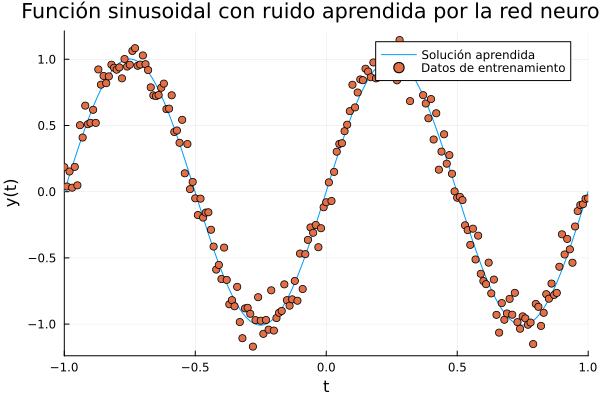

In [12]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, dataset_outs, label = "Datos de entrenamiento")

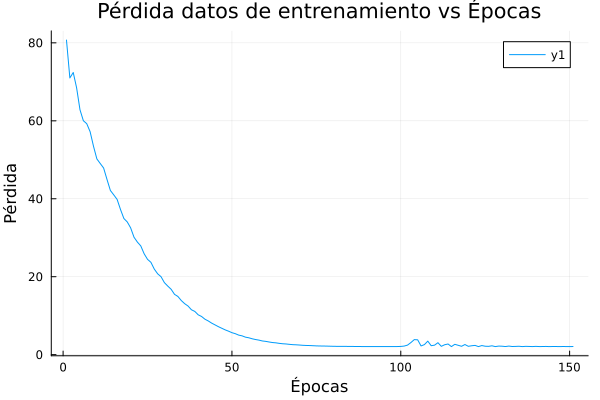

In [13]:
plot(losses, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 94.02985074626866


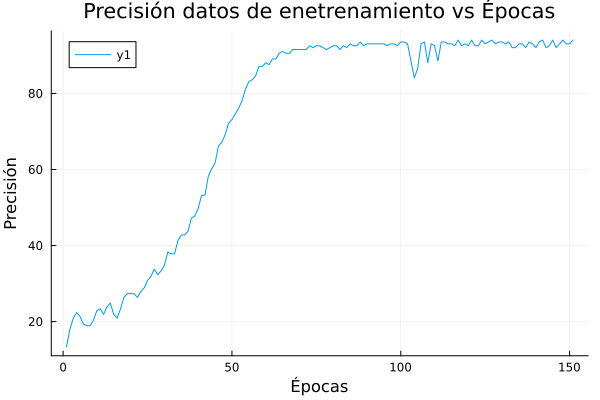

In [14]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys))
plot(accuracys, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

# Veamos con los datos de prueba

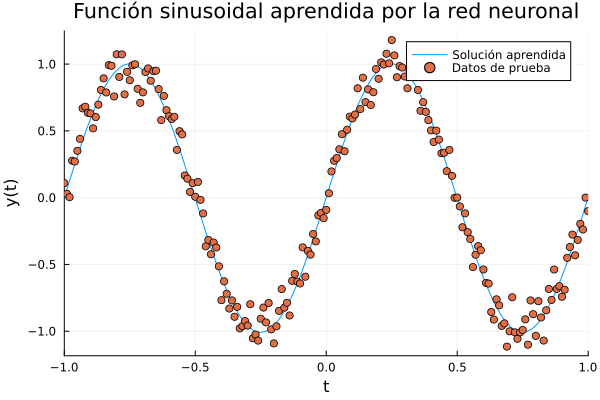

In [15]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, test_dataset, label = "Datos de prueba")

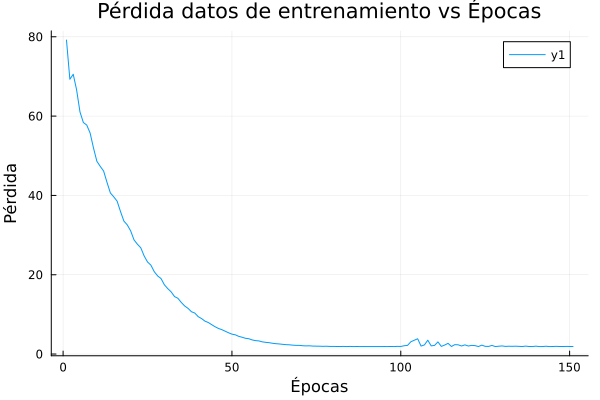

In [16]:
plot(losses_test, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de prueba: 97.51243781094527


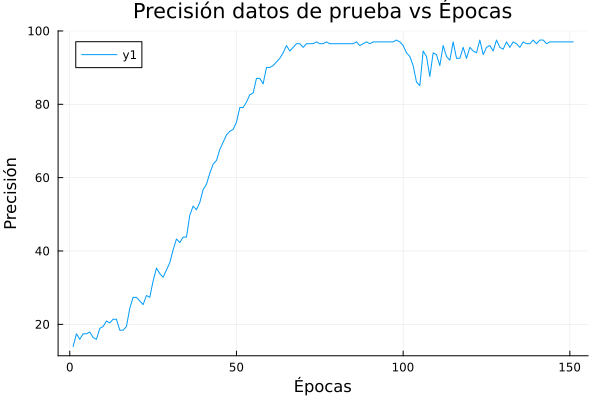

In [17]:
println("Maxima precisión en datos de prueba: ", maximum(accuracys_test))
plot(accuracys_test, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de prueba vs Épocas")

Como vemos esta NeuralODE comparada con los métodos anteriores mejora la presición en los datos de entrenamiento comparada con la red de varias capas que se creó con la red neuronal Feedfoward. Sin embargo esto depende mucho de las condiciones iniciales que se le de a la ecuación diferencial.